<h1 style="font-family:Corbel Light; color:#e54b87">Projet 4 : Anticipez les besoins en consommation de bâtiments </h1>

<h2 style="font-family:Corbel Light; color:#737373">Requirements</h2>

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

import hyperopt
from hyperopt import fmin, hp, tpe, Trials
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll import scope

import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LearningCurveDisplay
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OrdinalEncoder, PowerTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import mean_squared_log_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.compose import TransformedTargetRegressor

import category_encoders
from category_encoders.target_encoder import TargetEncoder

import xgboost as xgb
import catboost as ctb

from functools import partial
from math import ceil

import shap
import toolbox
import warnings

%matplotlib inline
pd.options.display.float_format = '{:_.5f}'.format
shap.initjs()

In [2]:
python_version = !python -V
print('python version :', python_version,'\n')
print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('scikit-learn version : ', sklearn.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')
print('XGBoost version : ', xgb.__version__, '\n')
print('CatBoost version : ', ctb.__version__, '\n')
print('SHAP version : ', shap.__version__, '\n')
print('hyperopt version : ', hyperopt.__version__, '\n') 
print('category_encoder version : ', category_encoders.__version__)

python version : ['Python 3.9.12'] 

pandas version :  1.4.2 

numpy version :  1.21.5 

matplotlib version :  3.5.1 

scikit-learn version :  1.2.1 

seaborn version :  0.12.1 

XGBoost version :  1.7.2 

CatBoost version :  1.1.1 

SHAP version :  0.41.0 

hyperopt version :  0.2.7 

category_encoder version :  2.5.1.post0


**Versions utilisées :**

- python : Python 3.9.12
- scikit-learn  :  1.2.1  
- seaborn    :  0.12.1
- matplotlib :  3.5.1 
- numpy  :  1.21.5 
- pandas :  1.4.2
- SHAP :  0.41.0
- CatBoost : 1.1.1
- XGBoost : 1.7.2
- hyperopt :  0.2.7 
- category_encoder version :  2.5.1.post0

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#e54b87">Étape 3</span> : Modélisation (Cible : Emissions de CO2)</h2>

<h3 style="font-family:Corbel Light; color:#737373">Inspection des données</h3>

In [3]:
data_building = pd.read_pickle('2016_Building_Energy_Benchmarking_Cleaned.pkl')

In [4]:
data_building.head()

,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,NumberofFloors,NumberofBuildings,YearBuilt,Neighborhood,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,NaturalGas(kBtu),Electricity(kBtu),SteamUse(kBtu),PropertyGFABuilding(s)
0,88434,88_434.00000,0.00000,0.00000,Hotel,NaN,NaN,12,1.00000,1927,downtown,60.00000,7_226_362.50000,249.98000,1_276_453.00000,3_946_027.00000,2_003_882.00000,88434
1,103566,83_880.00000,15_064.00000,4_622.00000,Hotel,Parking,Restaurant,11,1.00000,1996,downtown,61.00000,8_387_933.00000,295.86000,5_145_082.00000,3_242_851.00000,0.00000,88502
2,956110,756_493.00000,0.00000,0.00000,Hotel,NaN,NaN,41,1.00000,1969,downtown,43.00000,72_587_024.00000,2_089.28000,1_493_800.00000,49_526_664.00000,21_566_554.00000,759392
3,61320,61_320.00000,0.00000,0.00000,Hotel,NaN,NaN,10,1.00000,1926,downtown,56.00000,6_794_584.00000,286.43000,1_811_213.00000,2_768_924.00000,2_214_446.25000,61320
4,175580,123_445.00000,68_009.00000,0.00000,Hotel,Parking,Swimming Pool,18,1.00000,1980,downtown,75.00000,14_172_606.00000,505.01000,8_803_998.00000,5_368_607.00000,0.00000,113580


In [5]:
data_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PropertyGFATotal                 989 non-null    int64  
 1   LargestPropertyUseTypeGFA        989 non-null    float64
 2   SecondLargestPropertyUseTypeGFA  989 non-null    float64
 3   ThirdLargestPropertyUseTypeGFA   989 non-null    float64
 4   LargestPropertyUseType           989 non-null    object 
 5   SecondLargestPropertyUseType     488 non-null    object 
 6   ThirdLargestPropertyUseType      151 non-null    object 
 7   NumberofFloors                   989 non-null    int64  
 8   NumberofBuildings                989 non-null    float64
 9   YearBuilt                        989 non-null    int64  
 10  Neighborhood                     989 non-null    object 
 11  ENERGYSTARScore                  989 non-null    float64
 12  SiteEnergyUse(kBtu)   

On a 5 variables catégorielles : 

- A convertir en numérique : 
    - LargestPropertyUseType
    - Neighborhood


- A utiliser pour créer de nouvelles variables : 
    - YearBuilt 
    - SecondLargestPropertyUseType
    - ThirdLargestPropertyUseType

<h3 style="font-family:Corbel Light; color:#737373">Création de nouvelles variables</h3>

In [6]:
data_building_new = data_building.drop(columns=['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                                                'ThirdLargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
                                                'ThirdLargestPropertyUseType'])

<h4 style="font-family:Corbel Light; color:#737373">Surfaces</h4>

In [7]:
data_building_new['BuildingGFARatio'] = data_building_new['PropertyGFABuilding(s)'] / data_building_new['PropertyGFATotal']

In [8]:
data_building_new.drop(columns=['PropertyGFABuilding(s)'], inplace=True)

<h4 style="font-family:Corbel Light; color:#737373">Sources et proportions d'énergie</h4>

On ne va utiliser que les proportions de gaz naturel et de vapeur. La proportion d'électricité est trop corrélée linéairement avec la proportion de gaz naturel. 

In [9]:
data_building_new['EnergyTotal(kBtu)'] = data_building_new['Electricity(kBtu)'] + \
    data_building_new['NaturalGas(kBtu)'] + data_building_new['SteamUse(kBtu)']

print("valeurs nulles dans 'EnergyTotal(kBtu)' :",
      data_building_new.loc[data_building_new['EnergyTotal(kBtu)'] == 0.0].shape[0])

valeurs nulles dans 'EnergyTotal(kBtu)' : 0


In [10]:
data_building_new['NaturalGasRatio'] = data_building_new.apply(
    lambda row: row['NaturalGas(kBtu)'] / row['EnergyTotal(kBtu)'], axis=1)
data_building_new['SteamRatio'] = data_building_new.apply(
    lambda row: row['SteamUse(kBtu)'] / row['EnergyTotal(kBtu)'], axis=1)

In [11]:
data_building_new[['NaturalGasRatio', 'SteamRatio']].sample(5)

,NaturalGasRatio,SteamRatio
222,0.49790,0.00000
349,0.63704,0.00000
391,0.50544,0.00000
845,0.15680,0.00000
617,0.00000,0.00000


In [12]:
data_building_new.drop(columns=['NaturalGas(kBtu)', 'Electricity(kBtu)',
                                'SteamUse(kBtu)', 'EnergyTotal(kBtu)'], inplace=True)

<h4 style="font-family:Corbel Light; color:#737373">Ancienneté du bâtiment</h4>

On remplace la date de construction du bâtiment par son âge en 2016

In [13]:
data_building_new['AgeBuilding'] = 2016 - data_building_new['YearBuilt']
data_building_new[['YearBuilt', 'AgeBuilding']].head()

,YearBuilt,AgeBuilding
0,1927,89
1,1996,20
2,1969,47
3,1926,90
4,1980,36


In [14]:
data_building_new.drop(columns=['YearBuilt'], inplace=True)

<h4 style="font-family:Corbel Light; color:#737373">Nombre de bâtiments et d'étages</h4>

On va regrouper les bâtiments par nombre d'étage:

- low-rise : 4 étages ou moins
- mid rise : 5 à 9 étages
- high rise : 10 étages ou plus 

In [15]:
def group_floors(row: np.array):
    floor_n = row['NumberofFloors']
    if row['NumberofFloors'] == 0:
        floor_n = 1
    elif row['NumberofFloors'] > 4:
        if row['NumberofFloors'] < 10:
            floor_n = 5
        else:
            floor_n = 10

    return floor_n

In [16]:
data_building_new['NumberofFloors'].value_counts(normalize=True).sort_index()

0    0.01011
1    0.25379
2    0.19717
3    0.14863
4    0.09403
5    0.07583
6    0.05359
7    0.02831
8    0.01314
9    0.00708
10   0.01618
11   0.01416
12   0.00809
13   0.00506
14   0.00809
15   0.00506
16   0.00303
17   0.00404
18   0.00303
19   0.00404
20   0.00303
21   0.00303
22   0.00303
23   0.00303
24   0.00303
25   0.00303
27   0.00101
28   0.00101
29   0.00303
30   0.00101
33   0.00303
34   0.00202
36   0.00202
37   0.00101
41   0.00202
42   0.00506
46   0.00101
47   0.00101
49   0.00101
55   0.00101
56   0.00101
63   0.00101
76   0.00101
99   0.00101
Name: NumberofFloors, dtype: float64

In [17]:
data_building_new['NumberofFloors'] = data_building_new.apply(lambda row: group_floors(row), axis=1)

In [18]:
data_building_new['NumberofFloors'].value_counts(normalize=True).sort_index()

1    0.26390
2    0.19717
3    0.14863
4    0.09403
5    0.17796
10   0.11830
Name: NumberofFloors, dtype: float64

De même pour le nombre de bâtiments dans une même propriété

In [19]:
data_building_new['NumberofBuildings'].value_counts()

1.00000    953
0.00000     24
2.00000      3
4.00000      2
6.00000      2
9.00000      1
7.00000      1
5.00000      1
3.00000      1
8.00000      1
Name: NumberofBuildings, dtype: int64

In [20]:
data_building_new['NumberofBuildings'] = data_building_new.apply(
    lambda row: 2 if row['NumberofBuildings'] > 1 else row['NumberofBuildings'], axis=1)

In [21]:
data_building_new['NumberofBuildings'].value_counts()

1.00000    953
0.00000     24
2.00000     12
Name: NumberofBuildings, dtype: int64

<h4 style="font-family:Corbel Light; color:#737373">Localisation</h4>

In [22]:
data_building_new['Neighborhood'].value_counts(normalize=True)

downtown                0.24469
greater duwamish        0.20222
lake union              0.10111
magnolia / queen anne   0.08696
northeast               0.08089
east                    0.06572
northwest               0.05561
ballard                 0.03640
north                   0.03438
delridge                0.02730
central                 0.02528
southeast               0.02123
southwest               0.01820
Name: Neighborhood, dtype: float64

Aucun quartier en dessous de 1% donc on peut tous les garder sans les regrouper

<h4 style="font-family:Corbel Light; color:#737373">Etude des nouvelles variables</h4>

<h5 style="font-family:Corbel Light; color:#737373">Corrélations linéaires</h5>

On regarde s'il existe des corrélations linéaires entre les nouvelles variables (pour ne pas garder de variables avec une corrélation linéaire supérieure à 0.6)

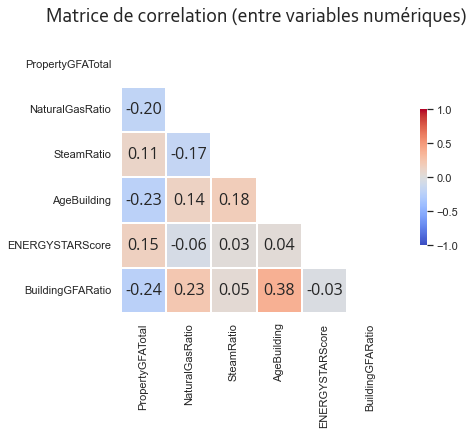

In [23]:
feature_numeric = ['PropertyGFATotal', 'NaturalGasRatio',
                   'SteamRatio', 'AgeBuilding', 'ENERGYSTARScore', 'BuildingGFARatio']

correlation_matrix = data_building_new[feature_numeric].corr()
toolbox.plot_heatmap_correlation_matrix(correlation_matrix,
                                        'Matrice de correlation (entre variables numériques)',
                                        (10, 5), 'coolwarm')

<h5 style="font-family:Corbel Light; color:#737373">Distributions</h5>

On regarde la distribution des nouvelles variables numériques : aucune ne semble gaussienne 

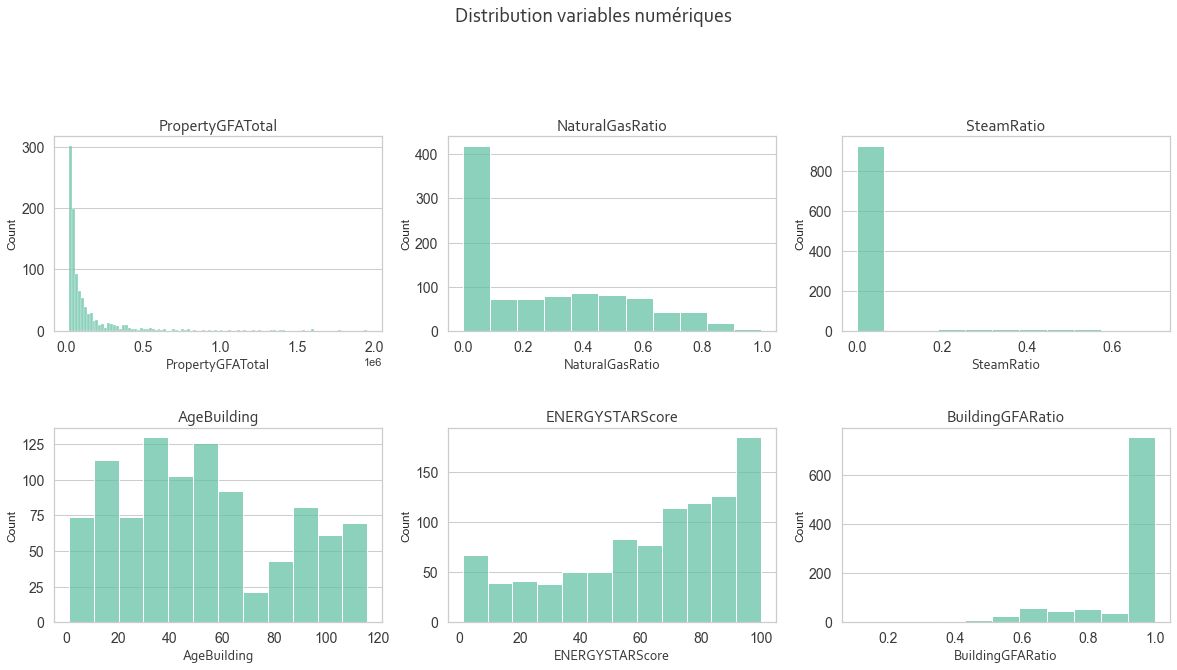

In [24]:
toolbox.display_distribution(data_building_new, feature_numeric, 3, (20, 10), hspace=0.5, top=0.8)

<h5 style="font-family:Corbel Light; color:#737373">Test transformations</h5>

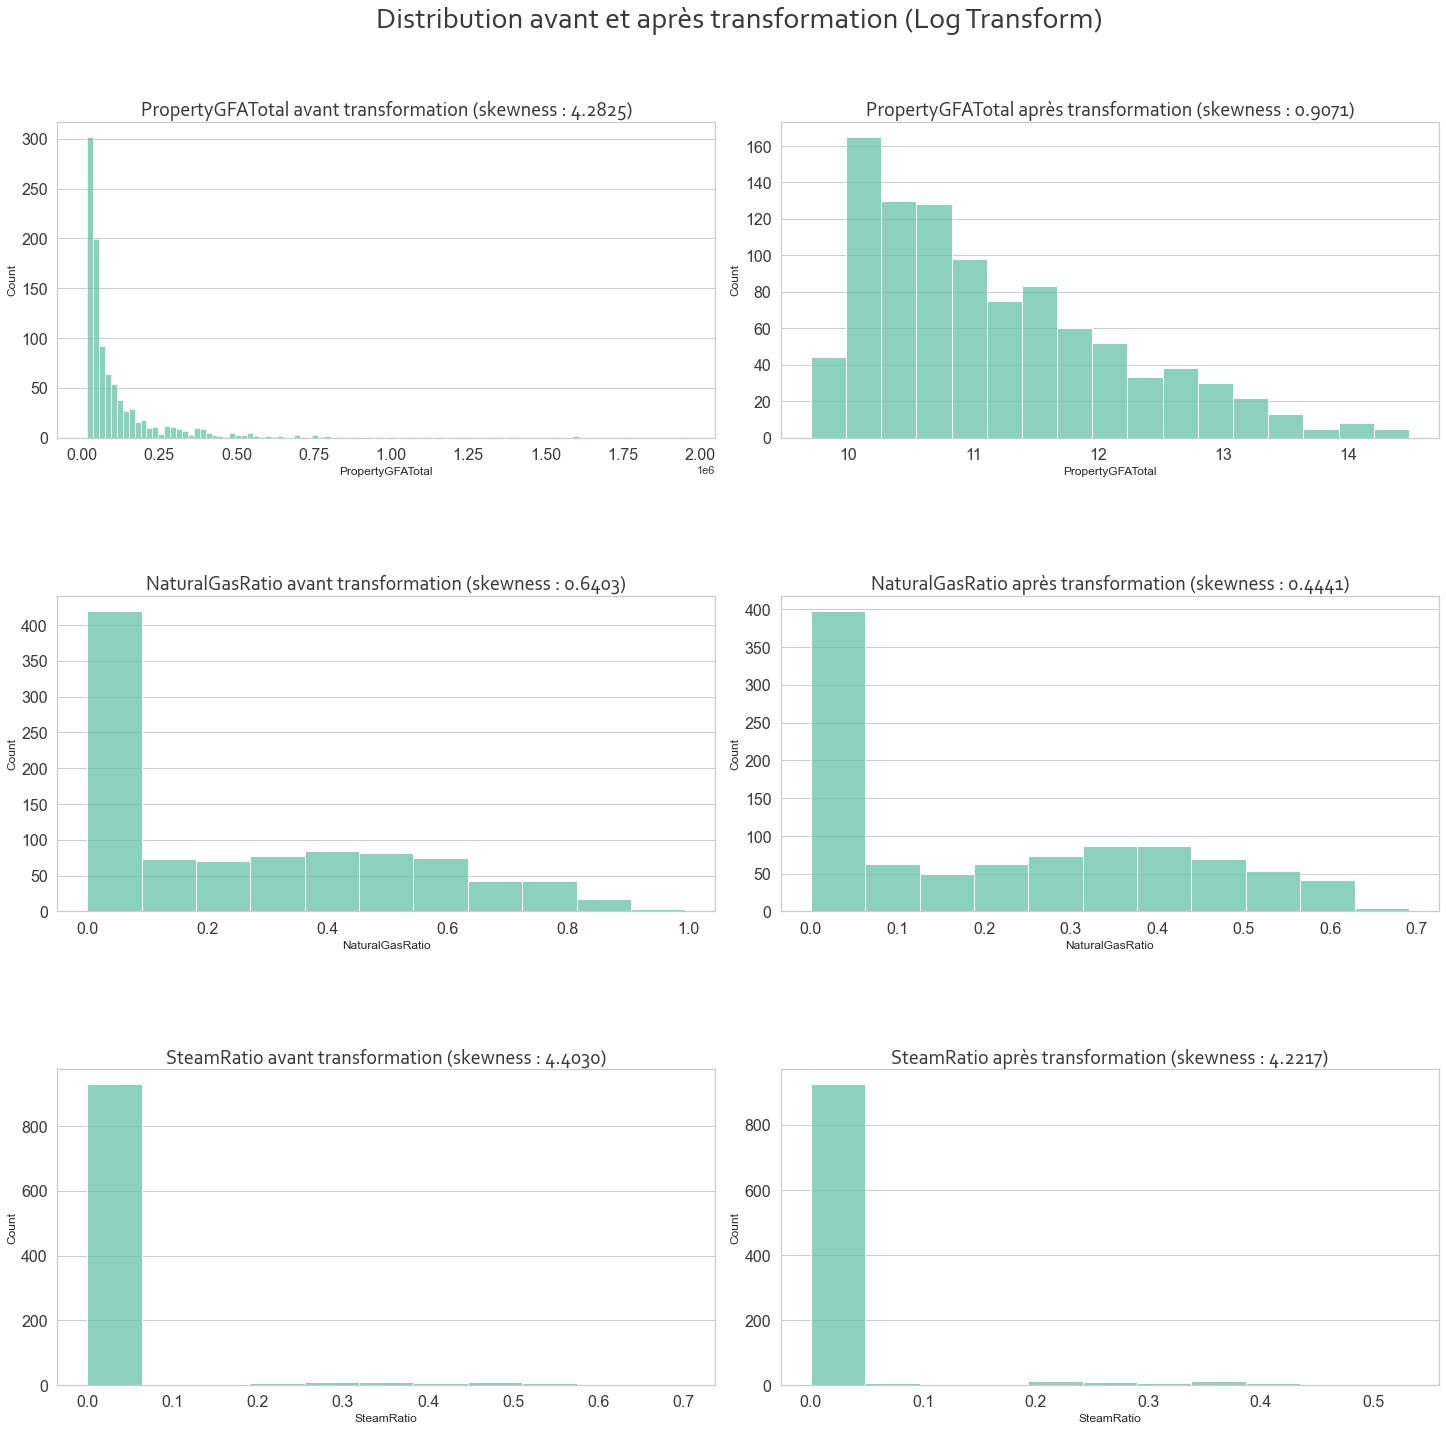

In [25]:
toolbox.test_transformer(data_building_new,
                         ['PropertyGFATotal', 'NaturalGasRatio', 'SteamRatio'],
                         [FunctionTransformer(np.log1p)],
                         'Log Transform', (20, 20), top=0.9, hspace=0.5)

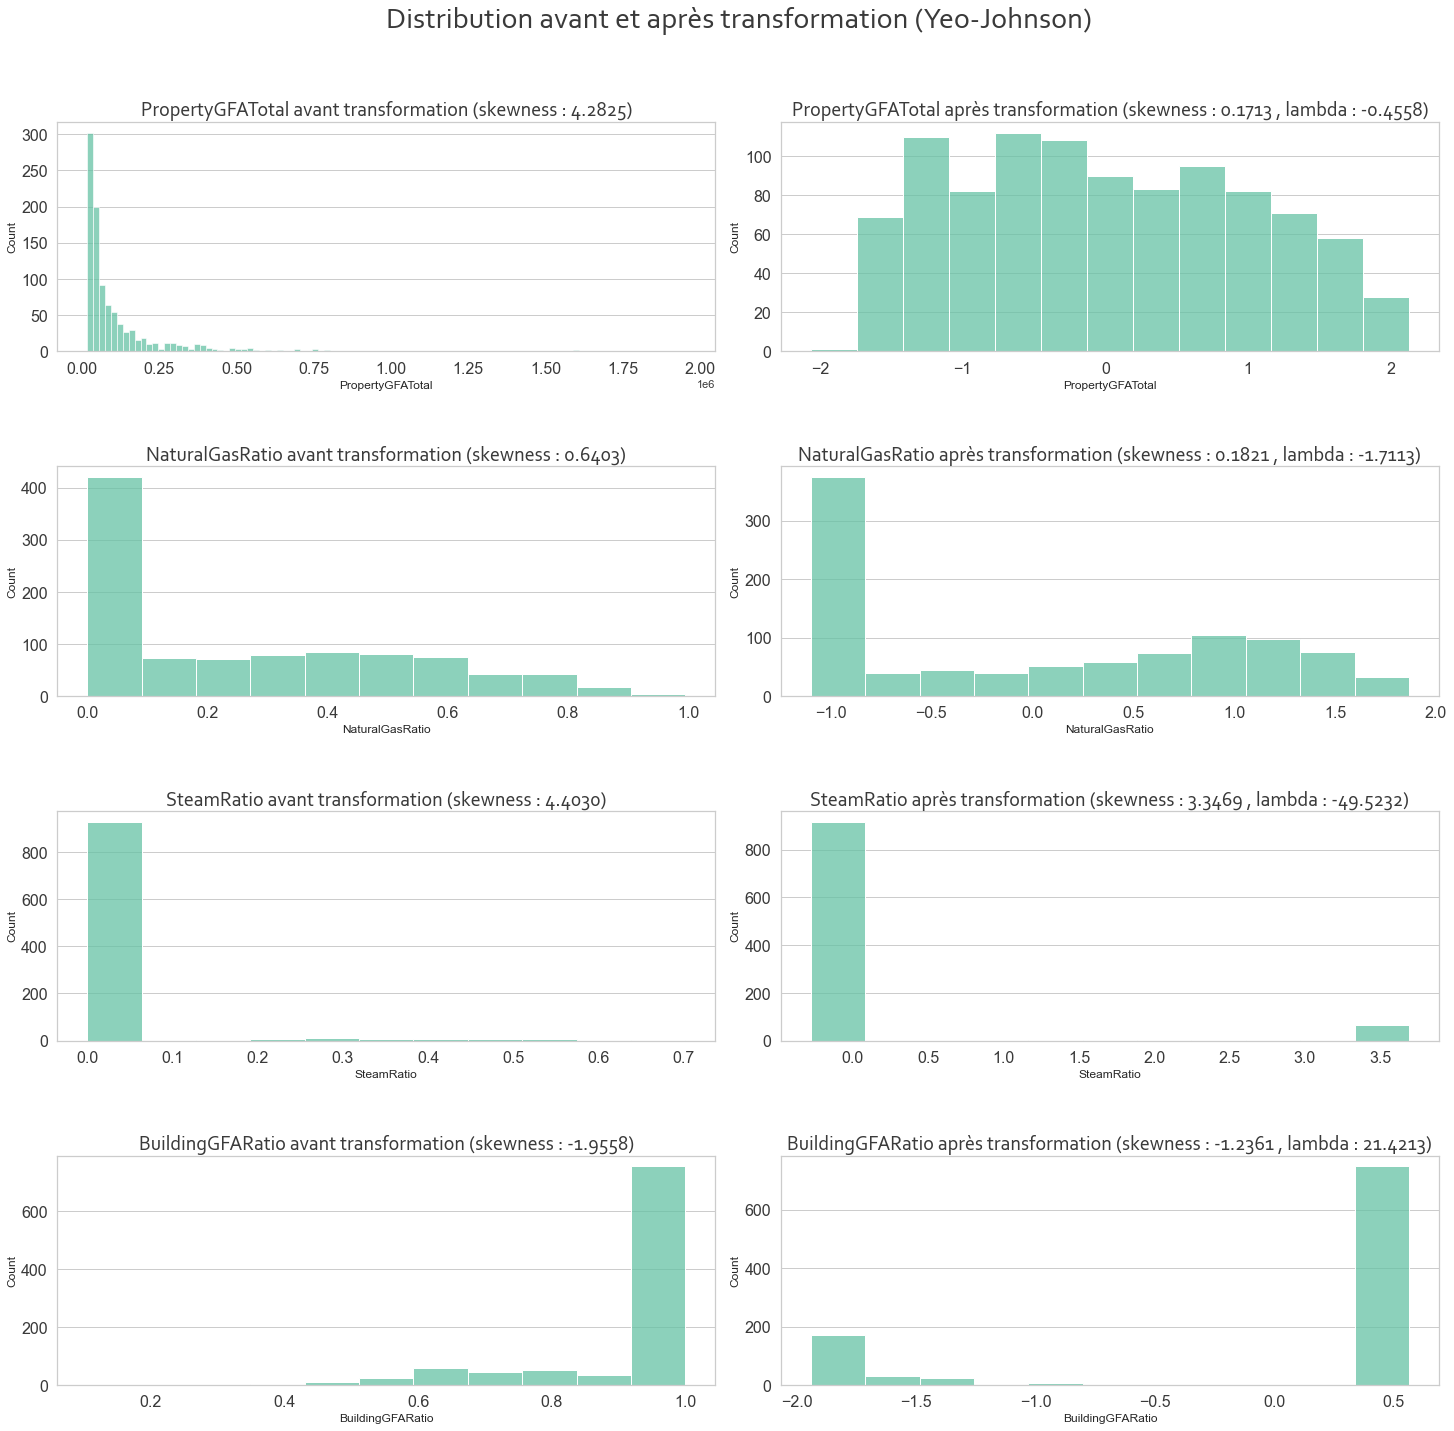

In [26]:
toolbox.test_transformer(data_building_new,
                         ['PropertyGFATotal', 'NaturalGasRatio',
                          'SteamRatio', 'BuildingGFARatio'],
                         [PowerTransformer(standardize=True)],
                         'Yeo-Johnson', (20, 20), top=0.9, hspace=0.5)

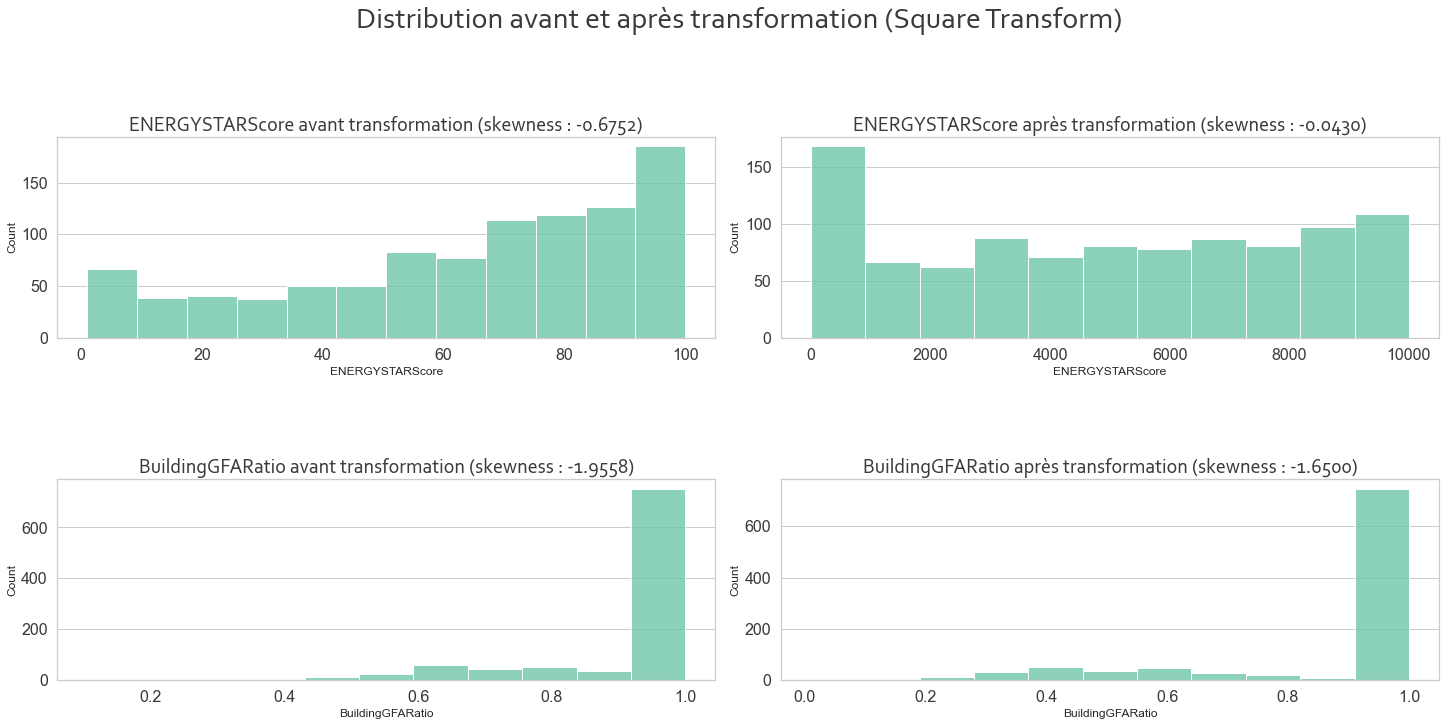

In [27]:
toolbox.test_transformer(data_building_new, ['ENERGYSTARScore', 'BuildingGFARatio'],
                         [FunctionTransformer(np.square)], 'Square Transform', (20, 10), top=0.8)

<h3 style="font-family:Corbel Light; color:#737373">Préparation des données</h3>

In [28]:
X = data_building_new.drop(columns=['ENERGYSTARScore', 'TotalGHGEmissions', 'SiteEnergyUse(kBtu)'])
y = data_building_new['TotalGHGEmissions']

In [29]:
X.shape

(989, 9)

<h4 style="font-family:Corbel Light; color:#737373">Choix des transformations </h4>

On va utiliser un Pipeline pour faire nos transformations - (voir exemple ci-dessous): 
- variables numériques : passage au log (si utile) + centrer/réduire avec un RobustScaler
- variables catégorielles nominales : transformation en variables numériques avec un TargetEncoder
- variables catégorielles ordinales : transformation en variables numériques avec un OrdinalEncoder

In [30]:
transformers = [{'feature': ['NaturalGasRatio', 'PropertyGFATotal', 'SteamRatio', 'BuildingGFARatio'],
                 'estimator': [PowerTransformer(standardize=True)]},
                {'feature': ['AgeBuilding'],
                 'estimator': [RobustScaler()]},
                {'feature': ['Neighborhood',  'LargestPropertyUseType'],
                 'estimator': [TargetEncoder(), RobustScaler()]},
                {'feature': ['NumberofFloors', 'NumberofBuildings'],
                 'estimator': [OrdinalEncoder()]}
                ]

preprocessor = toolbox.make_preprocessor(transformers)
pipeline = make_pipeline(preprocessor, LinearRegression())
pipeline

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['NaturalGasRatio',
                                                   'PropertyGFATotal',
                                                   'SteamRatio',
                                                   'BuildingGFARatio']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['AgeBuilding']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('targetencoder',
                                                                   TargetEncoder()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Neighborhood',
                                                   'LargestPropertyUseType']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['NumberofFloors',
                                                   'NumberofBuildings'])])),
                ('linearregression', LinearRegression())])

<h3 style="font-family:Corbel Light; color:#737373">Modèles</h3>

On va chercher à : 
- faire diminuer la RMSE et MAE (indiquent à quel point les valeurs prédites sont éloignées des vraies valeurs)
- faire tendre R2 vers 1 (indique à quel point les valeurs prédites sont linéairement corrélées aux vraies valeurs)

In [31]:
X.columns

Index(['PropertyGFATotal', 'LargestPropertyUseType', 'NumberofFloors',
       'NumberofBuildings', 'Neighborhood', 'BuildingGFARatio',
       'NaturalGasRatio', 'SteamRatio', 'AgeBuilding'],
      dtype='object')

In [32]:
transformers = [{'feature': ['NaturalGasRatio', 'PropertyGFATotal', 'SteamRatio', 'BuildingGFARatio'], 
                 'estimator': [PowerTransformer(standardize=True)]},
                {'feature': ['AgeBuilding'], 'estimator': [RobustScaler()]},
                {'feature': ['Neighborhood',  'LargestPropertyUseType'],
                 'estimator': [TargetEncoder(), RobustScaler()]},
                {'feature': ['NumberofFloors', 'NumberofBuildings'],
                 'estimator': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)]}
                ]

feature_categ = ['Neighborhood',  'LargestPropertyUseType']

regressors = [
    {'name': 'dummy', 'regressor': DummyRegressor(strategy='median'), 'with_pipeline': True},
    {'name': 'linear_reg', 'regressor': LinearRegression(), 'with_pipeline': True},
    {'name': 'ridge_reg', 'regressor': Ridge(), 'with_pipeline': True},
    {'name': 'lasso', 'regressor': Lasso(), 'with_pipeline': True},
    {'name': 'elastic_net', 'regressor': ElasticNet(), 'with_pipeline': True},
    {'name': 'svm', 'regressor': LinearSVR(), 'with_pipeline': True},
    {'name': 'kernel_svm', 'regressor': SVR(kernel='rbf'), 'with_pipeline': True},
    {'name': 'krr', 'regressor': KernelRidge(kernel='rbf'), 'with_pipeline': True},
    {'name': 'mlp', 
     'regressor': MLPRegressor(hidden_layer_sizes=(X.shape[1], 1), random_state=8, activation='identity'), 
     'with_pipeline': True},
    {'name': 'bagging', 'regressor': BaggingRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'random_forest', 'regressor': RandomForestRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'adaboost', 'regressor': AdaBoostRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'gboost', 'regressor': GradientBoostingRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'xgboost', 'regressor': xgb.XGBRegressor(seed=8), 'with_pipeline': True},
    {'name': 'catboost', 
     'regressor': ctb.CatBoostRegressor(cat_features=feature_categ, random_seed=8), 
     'with_pipeline': False}
]

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    scores_emissions = toolbox.cross_validate_and_score(
        regressors, X, y, transformers, 5)

In [33]:
scores_test = scores_emissions.loc[scores_emissions['set'] == 'test']
scores_test.sort_values(['r2', "rmsle", 'fit_time'],
                        ascending=[False, True, True])

,model,set,rmsle,rmse,mape,r2,mse,mae,fit_time,rmsle_std,rmse_std,mape_std,r2_std,mse_std,mae_std
24,gboost,test,0.33998,359.51275,0.53574,0.71070,309_579.68132,82.09244,0.49061,0.03906,424.65311,0.07748,0.21565,574_892.76559,76.22766
26,xgboost,test,0.38728,393.96379,0.55669,0.69965,343_919.39477,88.93632,0.68891,0.02877,434.40986,0.06997,0.22999,605_635.27747,82.68492
2,linear_reg,test,0.43818,464.99885,0.62158,0.54339,392_255.40762,105.47427,0.29554,0.07284,419.56105,0.03466,0.21352,640_147.85314,90.30014
4,ridge_reg,test,0.43813,465.66866,0.62139,0.54297,393_065.01074,105.47994,0.32162,0.07280,419.78293,0.03472,0.21309,640_791.16255,90.27519
10,svm,test,0.44826,480.14744,0.63312,0.53193,400_147.86412,103.03380,0.16320,0.06853,411.83285,0.05985,0.19073,616_488.79173,89.30797
20,random_forest,test,0.39905,505.05233,0.56835,0.51324,453_960.11618,107.06848,1.56541,0.05293,445.96217,0.06493,0.18058,711_271.09993,98.73184
16,mlp,test,0.48615,452.84690,0.61316,0.50926,388_169.23489,110.15508,0.77061,0.06754,427.90060,0.03397,0.25527,651_468.73795,97.74953
18,bagging,test,0.45380,508.33372,0.63378,0.46342,439_369.69113,110.70924,0.32120,0.06410,425.40160,0.08916,0.18430,673_957.84580,96.63162
28,catboost,test,0.34458,540.46919,0.50770,0.45845,507_821.31554,104.40052,52.39548,0.04781,464.45061,0.04433,0.19165,756_687.56375,91.78869
22,adaboost,test,0.58543,564.60557,0.79152,0.37740,518_337.13281,123.84727,0.38822,0.06761,446.71880,0.19743,0.14884,727_089.31086,104.06873


In [34]:
scores_train = scores_emissions.loc[scores_emissions['set'] == 'train']
scores_train.sort_values(['r2', "rmsle", 'fit_time'],
                         ascending=[False, True, True])

,model,set,rmsle,rmse,mape,r2,mse,mae,fit_time,rmsle_std,rmse_std,mape_std,r2_std,mse_std,mae_std
27,xgboost,train,0.00344,17.81495,0.04264,0.99950,405.71524,4.72567,0.68891,0.00034,9.39909,0.00198,0.00047,446.62330,0.97655
25,gboost,train,0.16424,279.73874,0.34906,0.89297,89_191.59724,45.78457,0.49061,0.00689,104.58409,0.00866,0.04756,43_585.78094,9.18279
19,bagging,train,0.06807,342.61978,0.20094,0.83234,121_042.51443,45.04295,0.32120,0.00259,60.45000,0.00275,0.03500,37_966.65883,7.98182
29,catboost,train,0.12131,362.91431,0.28612,0.77640,137_208.65410,50.81606,52.39548,0.00667,74.17451,0.00975,0.13538,48_595.14692,8.07462
21,random_forest,train,0.04924,430.70087,0.17540,0.73825,190_654.31436,48.44608,1.56541,0.00151,71.77101,0.00203,0.02865,54_199.30326,8.63395
23,adaboost,train,0.40226,529.51749,0.62514,0.61065,290_801.16131,101.21591,0.38822,0.03474,102.04112,0.02934,0.02919,93_465.75414,20.56022
3,linear_reg,train,0.39321,595.62999,0.60567,0.51890,379_648.67052,102.74663,0.29554,0.01977,157.71360,0.01755,0.11094,155_132.18759,20.67808
5,ridge_reg,train,0.39318,596.31768,0.60557,0.51775,380_493.98681,102.76281,0.32162,0.01978,157.79484,0.01754,0.11105,155_508.61958,20.70415
17,mlp,train,0.44417,599.13052,0.60831,0.51394,391_613.57659,110.73613,0.77061,0.02177,180.71026,0.00970,0.15761,168_394.66389,25.64675
11,svm,train,0.40083,621.31799,0.60839,0.47994,419_466.26925,102.00639,0.16320,0.01981,182.83935,0.01969,0.14787,182_459.18508,21.71398


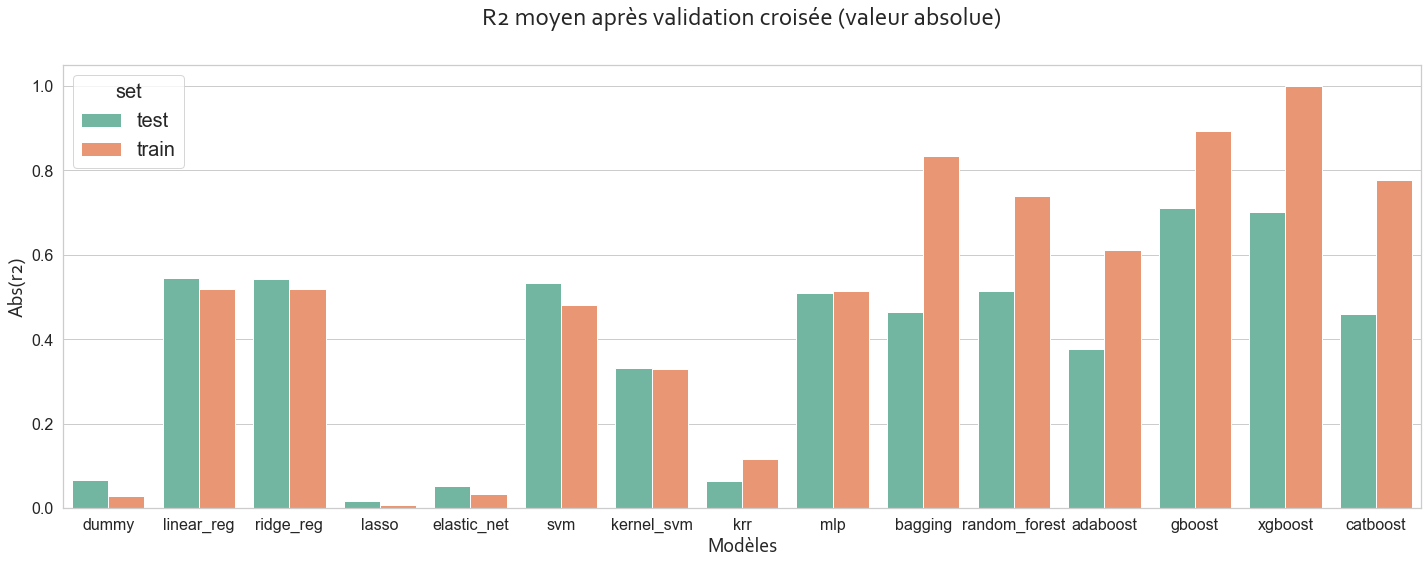

In [35]:
scores_copy = scores_emissions.copy()
scores_copy['Abs(r2)'] = scores_copy['r2'].abs()

titles = {"title": 'R2 moyen après validation croisée (valeur absolue)', 'xlabel': 'Modèles'}
toolbox.display_barplot(scores_copy, 'model', 'Abs(r2)', titles, (20, 8), 'set', True, 'Set2')

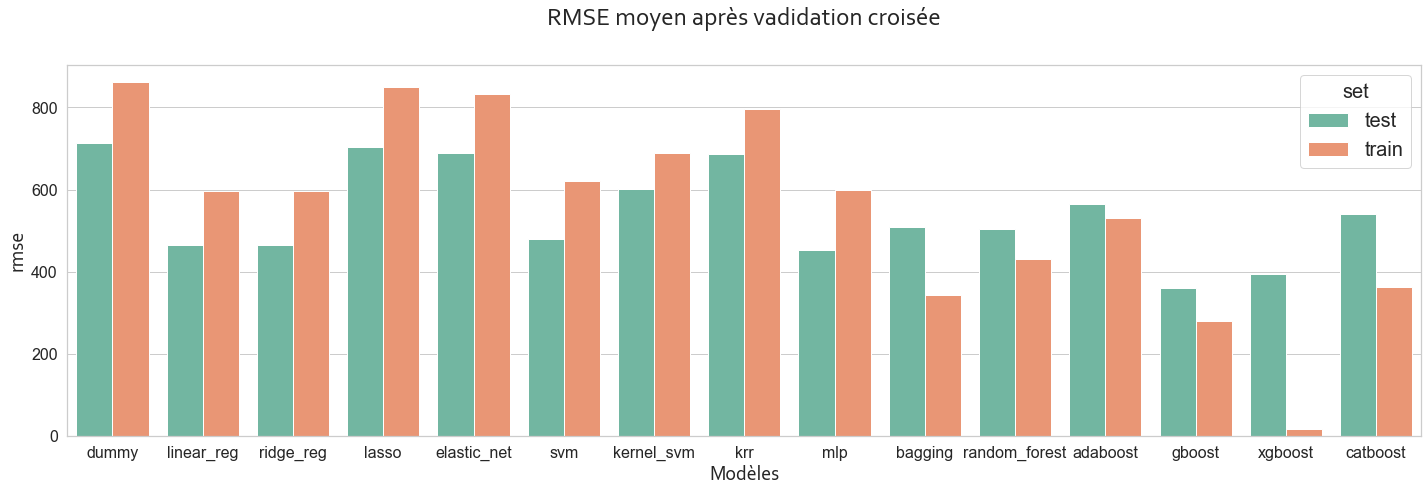

In [36]:
titles = {'title': 'RMSE moyen après vadidation croisée', 'xlabel': 'Modèles'}
toolbox.display_barplot(scores_copy, 'model', 'rmse', titles, (20, 7), 'set', True, 'Set2')

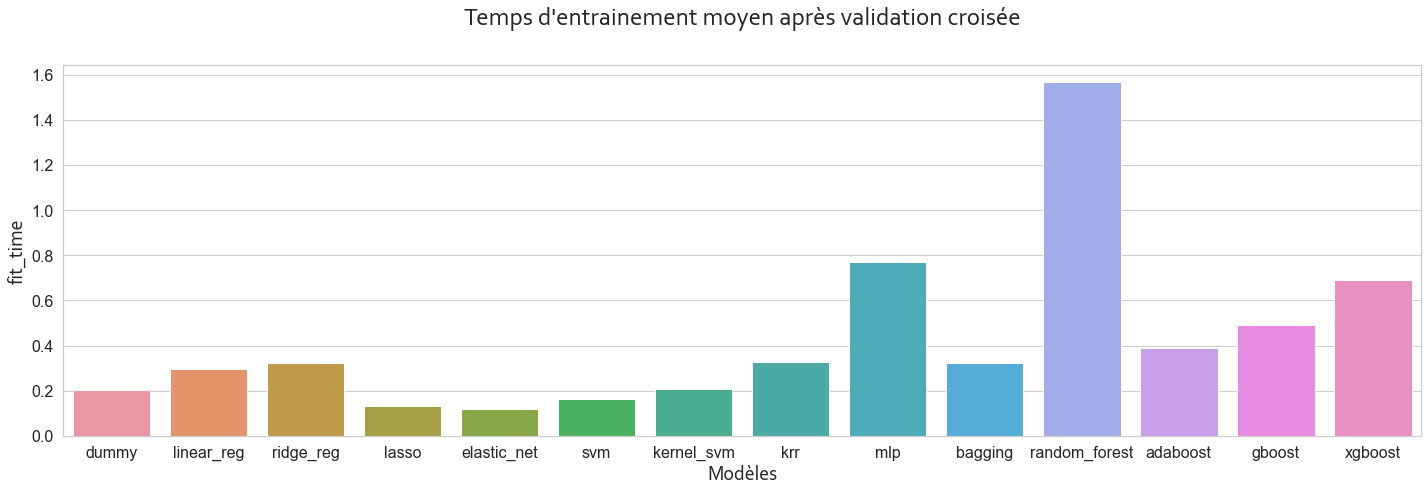

In [37]:
titles = {'title': 'Temps d\'entrainement moyen après validation croisée', 'xlabel': 'Modèles'}
toolbox.display_barplot(scores_copy.loc[scores_copy['model'] != 'catboost'], 'model', 'fit_time', titles, (20, 7))

<h3 style="font-family:Corbel Light; color:#737373">Analyse Importance des Features</h3>

In [38]:
transformers = [{'feature': ['NaturalGasRatio', 'PropertyGFATotal', 'SteamRatio', 'BuildingGFARatio'],
                 'estimator': [PowerTransformer(standardize=True)]},
                {'feature': ['AgeBuilding'], 'estimator': [RobustScaler()]},
                {'feature': ['Neighborhood',  'LargestPropertyUseType'],
                'estimator': [TargetEncoder(), RobustScaler()]},
                {'feature': ['NumberofFloors', 'NumberofBuildings'],
                 'estimator': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)]}
                ]

preprocessor = toolbox.make_preprocessor(transformers)

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

<h4 style="font-family:Corbel Light; color:#737373">Régression linéaire (coefficients)</h4>

On regarde les coefficients du modèle pour en déduire l'importance des variables.

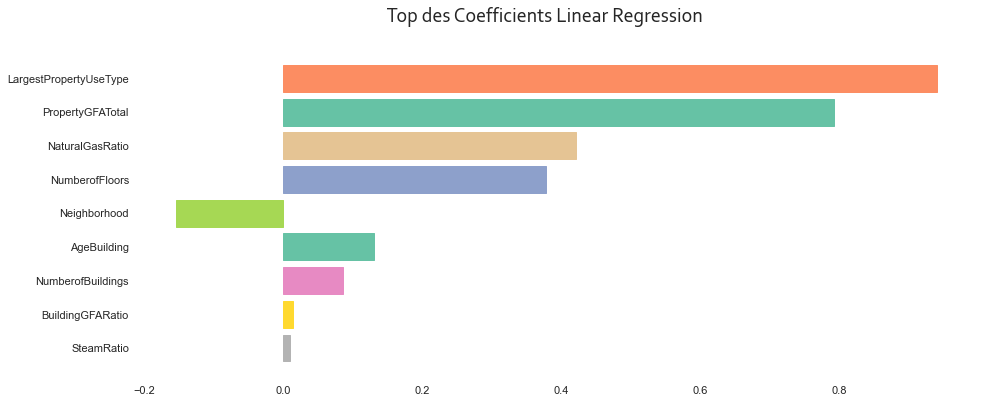

In [40]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    lr = toolbox.build_model(LinearRegression(), transformers)
    lr.fit(X_train, y_train)

toolbox.plot_top_features_linear_model(lr.regressor_, X_train, "Linear Regression", (15, 6))

<h4 style="font-family:Corbel Light; color:#737373">Modèles ensemblistes (gradient boost, xgboost, forêt aléatoire)</h4>

<Figure size 1656x720 with 0 Axes>

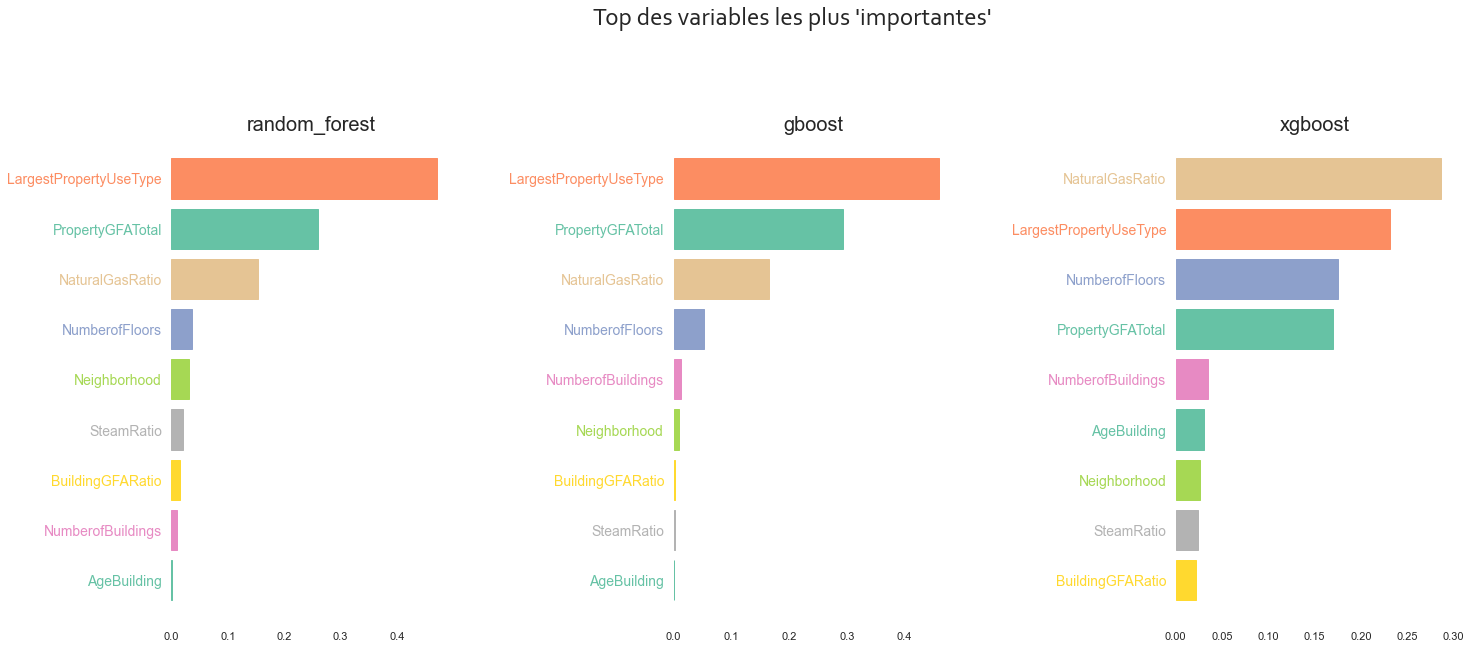

In [41]:
tree_models = []

regressors = [{'name': 'random_forest', 'regressor': RandomForestRegressor(random_state=8)},
              {'name': 'gboost', 'regressor': GradientBoostingRegressor(random_state=8)},
              {'name': 'xgboost', 'regressor': xgb.XGBRegressor(seed=8)}]

for model in regressors:
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        reg = toolbox.build_model(model['regressor'], transformers)
        reg.fit(X_train, y_train)

    tree_models.append({"name": model['name'], "model": reg.regressor_[1]})

toolbox.plot_feature_importance_tree_model(
    tree_models, X_train.columns, (23, 10), 20)

<h4 style="font-family:Corbel Light; color:#737373">SHAP (gradient boost)</h4>

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    gb = toolbox.build_model(GradientBoostingRegressor(random_state=8), transformers)
    gb.fit(X_train, y_train)

explainer = shap.TreeExplainer(gb.regressor_[1])

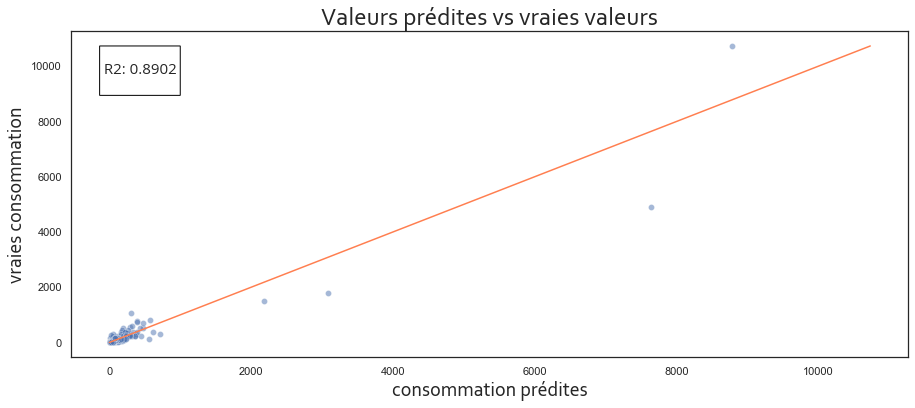

In [43]:
toolbox.plot_test_vs_pred(gb, y_test, X_test, 'TotalGHGEmissions', 'consommation', 1000)

In [44]:
y_pred = gb.predict(X_test)
error_df = X_test.copy()
error_df.insert(0, 'y_test', y_test)
error_df.insert(0, 'y_pred', y_pred)
error_df.insert(0, 'residuals', y_pred-y_test)
error_df.insert(0, 'logresidual', np.log1p(y_pred) - np.log1p(y_test))
error_df = error_df.reset_index()

Regardons pour quels types de bâtiments les émissions en CO2 sont les moins bien prédites

In [45]:
error_bytype = pd.DataFrame(error_df.groupby('LargestPropertyUseType')['residuals'].median()).reset_index()
error_bytype['rmsle'] = error_bytype.apply(lambda row: mean_squared_log_error(error_df.loc[error_df['LargestPropertyUseType'] == row['LargestPropertyUseType']]['y_test'],
                                                                              error_df.loc[error_df['LargestPropertyUseType'] == row['LargestPropertyUseType']]['y_pred'],
                                                                              squared=False), axis=1)
error_bytype.sort_values('rmsle', ascending=False)

,LargestPropertyUseType,residuals,rmsle
1,Data Center,-233.64867,1.61619
2,Distribution Center,-11.64296,1.09124
9,Parking,-280.02034,0.94789
7,Non-Refrigerated Warehouse,1.22489,0.79837
15,Wholesale Club/Supercenter,-116.72402,0.67263
4,Hotel,11.58595,0.66094
13,Senior Care Community,-156.95072,0.59234
8,Office,3.68791,0.51358
12,Retail Store,-0.63558,0.51255
14,Supermarket/Grocery Store,-32.75438,0.47936


Regardons de plus près pourquoi les consommations des centres de distributions sont mal prédites

In [46]:
error_df.loc[error_df['LargestPropertyUseType'] == 'Distribution Center'].sort_values('residuals', key=abs, ascending=False).head()

,index,logresidual,residuals,y_pred,y_test,PropertyGFATotal,LargestPropertyUseType,NumberofFloors,NumberofBuildings,Neighborhood,BuildingGFARatio,NaturalGasRatio,SteamRatio,AgeBuilding
158,248,-1.36149,-153.06508,51.74492,204.81000,161678,Distribution Center,1,1.00000,greater duwamish,1.00000,0.32330,0.00000,48
100,249,-2.75799,-143.96186,8.74814,152.71000,101101,Distribution Center,1,1.00000,greater duwamish,1.00000,0.00076,0.00000,67
252,931,-1.59568,-54.97699,12.98301,67.96000,28320,Distribution Center,1,1.00000,greater duwamish,1.00000,0.19658,0.00000,45
163,250,0.63867,29.51867,61.53867,32.02000,52613,Distribution Center,1,1.00000,greater duwamish,1.00000,0.50269,0.00000,36
159,504,0.53408,28.27020,67.32020,39.05000,35579,Distribution Center,1,1.00000,greater duwamish,1.00000,0.62062,0.00000,18


La librairie shap permet notamment de visualiser l'impact de chaque variable sur la prédiction de notre choix.

In [48]:
sample_idx = 159

shap_vals = explainer.shap_values(gb.regressor_[0].transform(X_test.iloc[sample_idx:sample_idx+1]))[0]

print("Expected/Base Value : ", explainer.expected_value)
print("\nShap Values for Sample %d : " % sample_idx, shap_vals)
print("\nPrediction From Model                            : ",
      gb.predict(X_test.iloc[sample_idx:sample_idx+1])[0])
print("Prediction From Adding SHAP Values to Base Value : ",
      np.exp(explainer.expected_value + shap_vals.sum()))

Expected/Base Value :  [3.97224177]

Shap Values for Sample 159 :  [ 1.19681549e+00 -5.62572986e-01 -6.56718700e-02  1.41091056e-02
  1.76797564e-01  5.79261930e-02 -6.20677469e-01  4.01402307e-02
  3.52355881e-04]

Prediction From Model                            :  67.32020348461806
Prediction From Adding SHAP Values to Base Value :  [67.32020348]


Par exemple, pour cette prédiction il semblerait que la surface totale du bien immobilier fasse beaucoup augmenter la valeur prédite en émissions alors que le type de propriété fait plutôt baisser cette valeur (les 2 représentations graphiques ci-dessous illustrent la même chose de deux manières différentes)

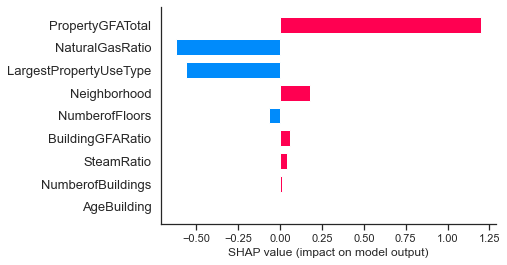

In [49]:
shap.bar_plot(shap_vals, feature_names=X_train.columns, max_display=15)

In [50]:
shap.force_plot(explainer.expected_value,
                explainer.shap_values(gb.regressor_[0].transform(X_test.iloc[sample_idx:sample_idx+1])),
                feature_names=X_train.columns,
                out_names='TotalGHGEmissions')

Shap permet également de visualiser l'impact de chaque variable sur l'ensemble des prédictions. Dans le graphique ci-dessous, chaque point correspond à une observation. Un point rouge indique une valeur élevée de la variable pour cette observation, un point bleu une valeur faible. 

On voit que des valeurs élevées pour la variable Surface Totale (PropertyGFATotal) font augmenter la valeur prédite d'émissions de CO2 alors que les variables mesurant l'age du bâtiment (AgeBuilding) et le pourcentage de vapeur utilisé (SteamRatio) ont peu d'impact peu importe leur valeur.

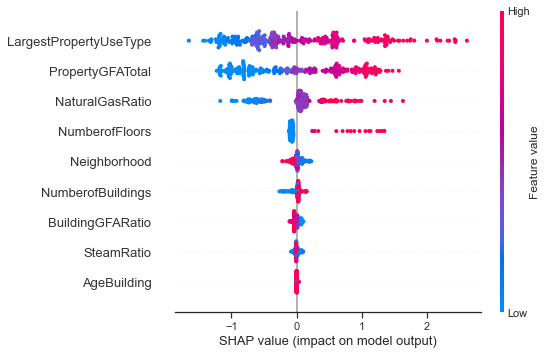

In [51]:
shap.summary_plot(explainer.shap_values(gb.regressor_[0].transform(X_test)),
                  features=gb.regressor_[0].transform(X_test),
                  feature_names=X_train.columns)

<h3 style="font-family:Corbel Light; color:#737373">Optimisation</h3>

On va optimiser le Gradient Boosting et le XGBoost

In [52]:
transformers = [{'feature': ['NaturalGasRatio', 'PropertyGFATotal', 'SteamRatio', 'BuildingGFARatio'], 'estimator': [PowerTransformer(standardize=True)]},
                {'feature': ['AgeBuilding'], 'estimator': [RobustScaler()]},
                {'feature': ['Neighborhood',  'LargestPropertyUseType'],
                 'estimator': [TargetEncoder(), RobustScaler()]},
                {'feature': ['NumberofFloors', 'NumberofBuildings'],
                 'estimator': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)]}
                ]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
datasets = {'X_train': X_train, 'y_train': y_train,
            'X_test': X_test, 'y_test': y_test}

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


<h4 style="font-family:Corbel Light; color:#737373">Gradient Boosting</h4>

In [53]:
# fonction à minimiser
def gb_r2_cv(params, X: np.array, y: np.array, transformers: dict, random_state=8, cv=5):
    reg = GradientBoostingRegressor(random_state=random_state, **params)
    model = toolbox.build_model(reg, transformers)

    score = -cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()

    return score


space_gb = {'n_estimators': scope.int(hp.quniform('n_estimators', 300, 1400, 1)),
            'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
            'learning_rate': hp.loguniform('learning_rate',  np.log(0.1), np.log(0.7)),
            'max_features': scope.int(hp.quniform('max_features', ceil(X.shape[1]/2), X.shape[1], 1)),
            # 'min_samples_leaf' : scope.int(hp.quniform('min_samples_leaf', 2, 10, 1)),
            # 'min_samples_split' : scope.int(hp.quniform('min_samples_split', 2, 15, 1))
            # 'n_iter_no_change' : scope.int(hp.quniform('n_iter_no_change', 1, 100, 1)),
            }

print("-R2 sans optimisation : {:.4f}\n".format(gb_r2_cv({}, X_train, y_train, transformers)))

trials_gb = Trials()
best_params_gb = fmin(fn=partial(gb_r2_cv, X=X_train, y=y_train, transformers=transformers),
                      space=space_gb,
                      algo=tpe.suggest,
                      max_evals=100,
                      trials=trials_gb,
                      rstate=np.random.default_rng(8),
                      early_stop_fn=no_progress_loss(30)
                      )

-R2 sans optimisation : -0.5952

 55%|█████▌    | 55/100 [03:35<02:56,  3.91s/trial, best loss: -0.6592134673841133]


Regardons la valeur du R2 pour chaque combinaison de paramètres testée par hyperopt

In [54]:
trials_df_gb = toolbox.build_trial_df(trials_gb, '-r2')
trials_df_gb.head()

,learning_rate,max_depth,max_features,n_estimators,-r2,trial_number
0,0.52996,5.00000,6.00000,880.00000,-0.39883,0
1,0.66995,3.00000,7.00000,617.00000,-0.38696,1
2,0.35383,3.00000,9.00000,1_014.00000,-0.52722,2
3,0.33539,5.00000,6.00000,1_106.00000,-0.27803,3
4,0.32444,4.00000,8.00000,638.00000,-0.46642,4


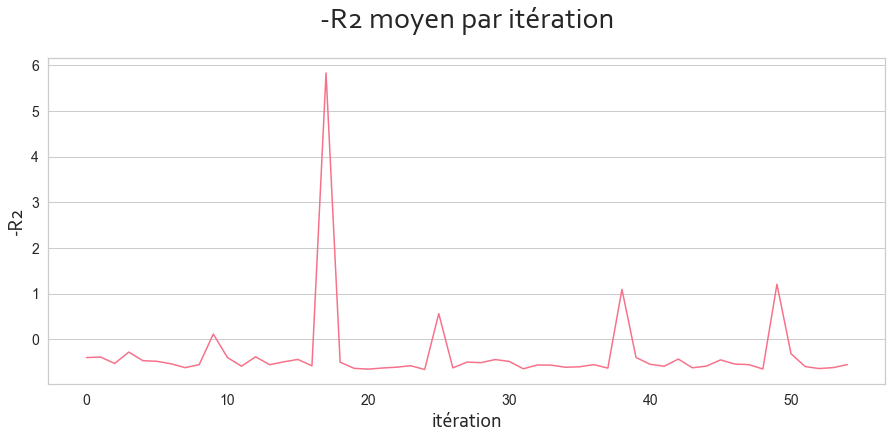

In [55]:
titles = {'title': '-R2 moyen par itération',
          'xlabel': 'itération',
          'ylabel': '-R2'}

toolbox.display_lineplot(trials_df_gb, 'trial_number',
                         '-r2', (15, 6), titles, grid_x=False)

In [57]:
best_model_gb = GradientBoostingRegressor(random_state=8, n_iter_no_change=60,
                                          n_estimators=int(best_params_gb['n_estimators']),
                                          max_depth=int(best_params_gb['max_depth']),
                                          learning_rate=best_params_gb['learning_rate'],
                                          max_features=int(best_params_gb['max_features']),
                                          # n_iter_no_change=int(best_params_gb['n_iter_no_change']),
                                          # min_samples_leaf=int(best_params_gb['min_samples_leaf']),
                                          # min_samples_split=int(best_params_gb['min_samples_split'])
                                          )

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    best_model_gb_fit = toolbox.score_best_model(best_model_gb, transformers, best_params_gb, datasets)

,Param,Best Param
0,learning_rate,0.14689
1,max_depth,2.00000
2,max_features,5.00000
3,n_estimators,388.00000


Modèle optimisé : 
Test R2 : 0.8592
Temps d'entrainement : 0.422
Train R2 : 0.9066

Ecart type R2 (validation croisée sur train set) : 0.3272


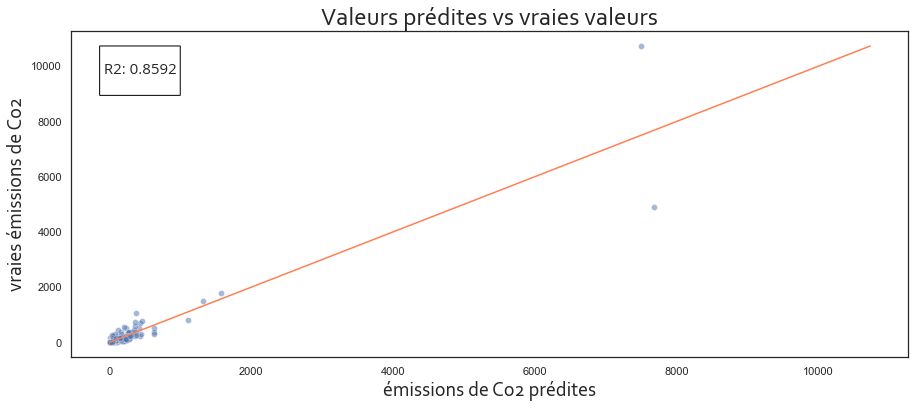

In [58]:
toolbox.plot_test_vs_pred(best_model_gb_fit, y_test, X_test, 'TotalGHGEmissions', 'émissions de Co2', 1000)

<h4 style="font-family:Corbel Light; color:#737373">XGBoost</h4>

In [59]:
# fonction à minimiser
def xgb_r2_cv(params, X: np.array, y: np.array, transformers: dict, random_state=8, cv=5):
    reg = xgb.XGBRegressor(seed=random_state, **params)
    model = toolbox.build_model(reg, transformers)

    score = -cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()

    return score


space_xgb = {'eta': hp.loguniform('eta', np.log(0.1), np.log(0.7)),
             'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
             'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
             'gamma': hp.uniform('gamma', 0, 100),
             'reg_lambda': hp.uniform('reg_lambda', 0, 100),
             'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1400, 1)),
             'subsample': hp.uniform('subsample', 0.7, 1)
             }

print("-R2 sans optimisation : {:.4f}\n".format(xgb_r2_cv({}, X_train, y_train, transformers)))

trials_xgb = Trials()

best_params_xgb = fmin(fn=partial(xgb_r2_cv, X=X_train, y=y_train, transformers=transformers),
                       space=space_xgb,
                       algo=tpe.suggest,
                       max_evals=60,
                       trials=trials_xgb,
                       rstate=np.random.default_rng(8),
                       early_stop_fn=no_progress_loss(30)
                       )

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


-R2 sans optimisation : -0.5450

100%|██████████| 60/60 [01:37<00:00,  1.62s/trial, best loss: -0.6153798492691379] 


In [60]:
trials_df_xgb = toolbox.build_trial_df(trials_xgb, '-r2')
trials_df_xgb.head()

,colsample_bytree,eta,gamma,max_depth,n_estimators,reg_lambda,subsample,-r2,trial_number
0,0.41203,0.20579,99.82739,5.00000,1_321.00000,16.71994,0.85819,-0.02838,0
1,0.44157,0.55946,61.56246,5.00000,319.00000,59.15687,0.78656,-0.04333,1
2,0.66686,0.52378,55.39717,4.00000,520.00000,94.10146,0.89480,-0.03287,2
3,0.77629,0.39401,31.42518,4.00000,1_365.00000,35.79237,0.91973,-0.10601,3
4,0.99296,0.44610,56.00976,4.00000,893.00000,69.38029,0.79222,-0.04326,4


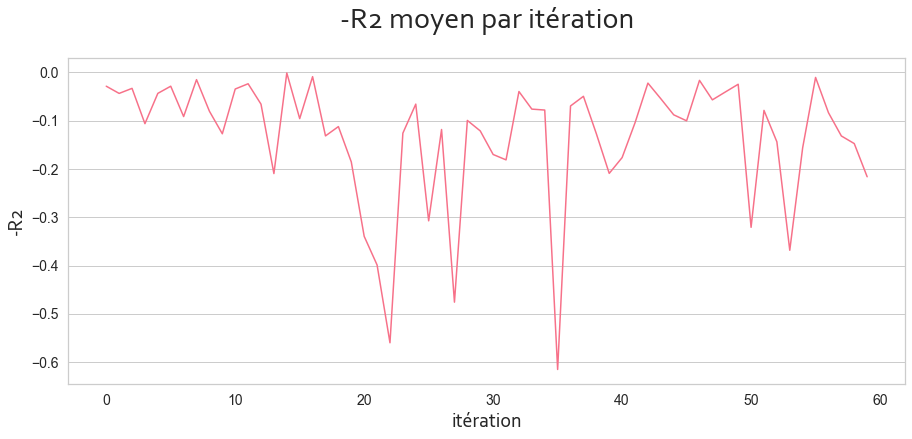

In [61]:
titles = {'title': '-R2 moyen par itération',
          'xlabel': 'itération',
          'ylabel': '-R2'}

toolbox.display_lineplot(trials_df_xgb, 'trial_number',
                         '-r2', (15, 6), titles, grid_x=False)

In [65]:
best_model_xgb = xgb.XGBRegressor(seed=8,
                                  max_depth=int(best_params_xgb['max_depth']),
                                  eta=best_params_xgb['eta'],
                                  colsample_bytree=best_params_xgb['colsample_bytree'],
                                  gamma=best_params_xgb['gamma'],
                                  # reg_lambda=best_params_xgb['reg_lambda'],
                                  n_estimators=int(best_params_xgb['n_estimators']),
                                  subsample=best_params_xgb['subsample']
                                  )

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    best_model_xgb_fit = toolbox.score_best_model(
        best_model_xgb, transformers, best_params_xgb, datasets)

,Param,Best Param
0,colsample_bytree,0.31582
1,eta,0.18335
2,gamma,0.11999
3,max_depth,3.00000
4,n_estimators,581.00000
5,reg_lambda,8.28944
6,subsample,0.81052


Modèle optimisé : 
Test R2 : 0.9129
Temps d'entrainement : 0.659
Train R2 : 0.9371

Ecart type R2 (validation croisée sur train set) : 0.3582


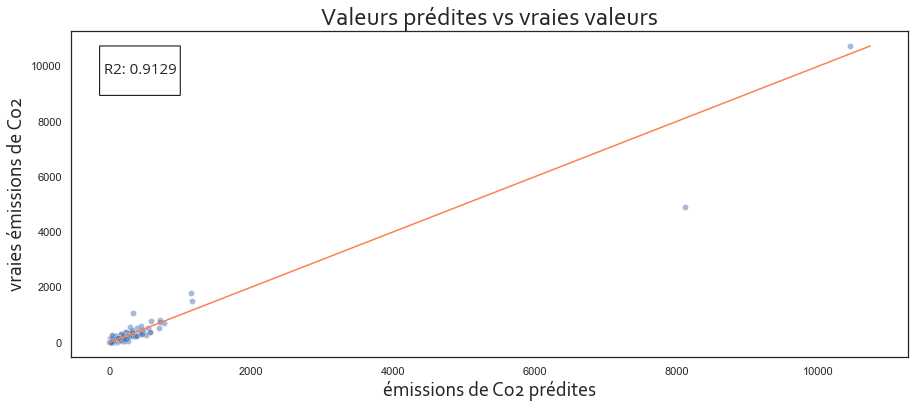

In [63]:
toolbox.plot_test_vs_pred(best_model_xgb_fit, y_test, X_test, 'TotalGHGEmissions', 'émissions de Co2', 1_000)

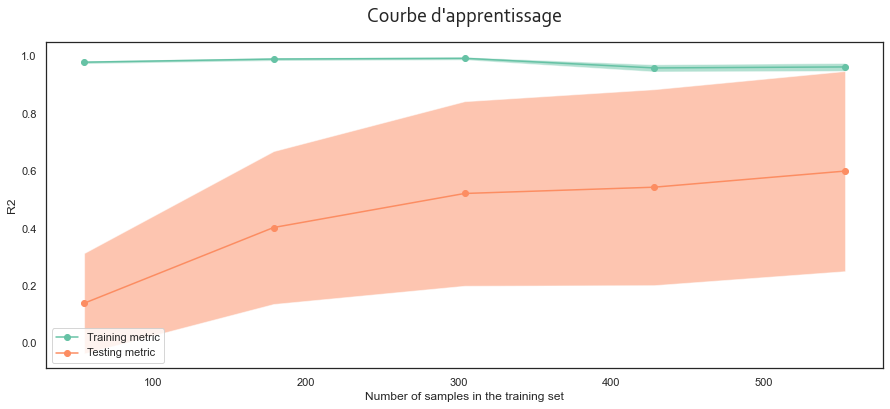

In [66]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    toolbox.display_learning_curve(best_model_xgb, X_train, y_train, transformers, (15, 6))

<h3 style="font-family:Corbel Light; color:#737373">Modèles avec Energy Star Score</h3>

In [67]:
X_star = data_building_new.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'])
X_star.columns

Index(['PropertyGFATotal', 'LargestPropertyUseType', 'NumberofFloors',
       'NumberofBuildings', 'Neighborhood', 'ENERGYSTARScore',
       'BuildingGFARatio', 'NaturalGasRatio', 'SteamRatio', 'AgeBuilding'],
      dtype='object')

In [68]:
transformers_star = [{'feature': ['NaturalGasRatio', 'PropertyGFATotal', 'SteamRatio', 'BuildingGFARatio'], 'estimator': [PowerTransformer(standardize=True)]},
                     {'feature': ['AgeBuilding'],
                      'estimator': [RobustScaler()]},
                     {'feature': ['Neighborhood',  'LargestPropertyUseType'], 
                      'estimator': [TargetEncoder(), RobustScaler()]},
                     {'feature': ['NumberofFloors', 'NumberofBuildings'],
                      'estimator': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)]},
                     {'feature': ['ENERGYSTARScore'], 
                      'estimator': [FunctionTransformer(np.square), RobustScaler()]}
                     ]

feature_categ = ['LargestPropertyUseType', 'Neighborhood']

regressors = [
    {'name': 'dummy', 'regressor': DummyRegressor(strategy='median'), 'with_pipeline': True},
    {'name': 'linear_reg', 'regressor': LinearRegression(), 'with_pipeline': True},
    {'name': 'ridge_reg', 'regressor': Ridge(), 'with_pipeline': True},
    {'name': 'lasso', 'regressor': Lasso(), 'with_pipeline': True},
    {'name': 'elastic_net', 'regressor': ElasticNet(), 'with_pipeline': True},
    {'name': 'svm', 'regressor': LinearSVR(), 'with_pipeline': True},
    {'name': 'kernel_svm', 'regressor': SVR(kernel='rbf'), 'with_pipeline': True},
    {'name': 'krr', 'regressor': KernelRidge(kernel='rbf'), 'with_pipeline': True},
    {'name': 'mlp', 
     'regressor': MLPRegressor(hidden_layer_sizes=(X_star.shape[1], 1), random_state=8, activation='identity'), 
     'with_pipeline': True},
    {'name': 'bagging', 'regressor': BaggingRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'random_forest', 'regressor': RandomForestRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'adaboost', 'regressor': AdaBoostRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'gboost', 'regressor': GradientBoostingRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'xgboost', 'regressor': xgb.XGBRegressor(seed=8), 'with_pipeline': True},
    {'name': 'catboost', 
     'regressor': ctb.CatBoostRegressor(cat_features=feature_categ, random_seed=8), 
     'with_pipeline': False}
]

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    scores_emissions_star = toolbox.cross_validate_and_score(regressors, X_star, y, transformers_star, 5)

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


In [69]:
scores_emissions_star.insert(0, 'energy_star_score', 'avec')
scores_emissions.insert(0, 'energy_star_score', 'sans')
scores_emissions_all = pd.concat([scores_emissions, scores_emissions_star], ignore_index=True)

In [70]:
scores_test_all = scores_emissions_all.loc[scores_emissions_all['set'] == 'test']
scores_test_all.sort_values(['r2', "rmsle", 'fit_time'], ascending=[False, True, True]).head(10)

,energy_star_score,model,set,rmsle,rmse,mape,r2,mse,mae,fit_time,rmsle_std,rmse_std,mape_std,r2_std,mse_std,mae_std
24,sans,gboost,test,0.33998,359.51275,0.53574,0.71070,309_579.68132,82.09244,0.49061,0.03906,424.65311,0.07748,0.21565,574_892.76559,76.22766
26,sans,xgboost,test,0.38728,393.96379,0.55669,0.69965,343_919.39477,88.93632,0.68891,0.02877,434.40986,0.06997,0.22999,605_635.27747,82.68492
54,avec,gboost,test,0.22429,411.27777,0.39775,0.64697,328_436.03411,78.49402,0.56441,0.03330,399.10730,0.06041,0.16547,561_603.69535,65.66283
56,avec,xgboost,test,0.23589,434.72110,0.40182,0.64048,348_159.07623,84.25541,0.39721,0.04093,398.96948,0.05121,0.14101,565_363.83545,76.35743
32,avec,linear_reg,test,0.35653,441.58671,0.51488,0.54701,358_436.91865,103.16911,0.13641,0.11671,404.27478,0.03127,0.24660,591_813.34051,94.17230
34,avec,ridge_reg,test,0.35642,442.39491,0.51462,0.54653,358_603.41653,103.05209,0.18000,0.11651,403.59653,0.03061,0.24529,590_930.25168,93.76147
40,avec,svm,test,0.36775,460.62449,0.52050,0.54432,380_465.14295,104.90438,0.22560,0.11714,410.23192,0.02455,0.20900,616_224.67564,95.58090
2,sans,linear_reg,test,0.43818,464.99885,0.62158,0.54339,392_255.40762,105.47427,0.29554,0.07284,419.56105,0.03466,0.21352,640_147.85314,90.30014
4,sans,ridge_reg,test,0.43813,465.66866,0.62139,0.54297,393_065.01074,105.47994,0.32162,0.07280,419.78293,0.03472,0.21309,640_791.16255,90.27519
10,sans,svm,test,0.44826,480.14744,0.63312,0.53193,400_147.86412,103.03380,0.16320,0.06853,411.83285,0.05985,0.19073,616_488.79173,89.30797


In [71]:
scores_train_all = scores_emissions_all.loc[scores_emissions_all['set'] == 'train']
scores_train_all.sort_values(['r2', "rmsle", 'fit_time'], ascending=[False, True, True]).head(10)

,energy_star_score,model,set,rmsle,rmse,mape,r2,mse,mae,fit_time,rmsle_std,rmse_std,mape_std,r2_std,mse_std,mae_std
57,avec,xgboost,train,0.00077,5.56332,0.02050,0.99995,31.41996,2.22402,0.39721,0.00012,0.68514,0.00168,0.00002,7.60561,0.29256
27,sans,xgboost,train,0.00344,17.81495,0.04264,0.99950,405.71524,4.72567,0.68891,0.00034,9.39909,0.00198,0.00047,446.62330,0.97655
55,avec,gboost,train,0.08143,228.33518,0.23978,0.92495,60_696.92134,38.31061,0.56441,0.00434,92.52008,0.00657,0.04732,37_147.20148,8.80424
25,sans,gboost,train,0.16424,279.73874,0.34906,0.89297,89_191.59724,45.78457,0.49061,0.00689,104.58409,0.00866,0.04756,43_585.78094,9.18279
59,avec,catboost,train,0.04664,264.05830,0.16718,0.86102,73_076.88615,36.36094,50.20133,0.00486,57.88003,0.00895,0.13321,29_314.97921,4.60388
19,sans,bagging,train,0.06807,342.61978,0.20094,0.83234,121_042.51443,45.04295,0.32120,0.00259,60.45000,0.00275,0.03500,37_966.65883,7.98182
49,avec,bagging,train,0.05429,351.85623,0.17470,0.81659,126_996.90555,45.00224,0.32280,0.00369,56.51633,0.00374,0.05666,39_889.30795,7.90346
29,sans,catboost,train,0.12131,362.91431,0.28612,0.77640,137_208.65410,50.81606,52.39548,0.00667,74.17451,0.00975,0.13538,48_595.14692,8.07462
21,sans,random_forest,train,0.04924,430.70087,0.17540,0.73825,190_654.31436,48.44608,1.56541,0.00151,71.77101,0.00203,0.02865,54_199.30326,8.63395
51,avec,random_forest,train,0.03740,436.11993,0.14507,0.73142,195_286.11291,47.75442,1.78463,0.00108,71.31283,0.00284,0.02730,54_755.62334,8.68986


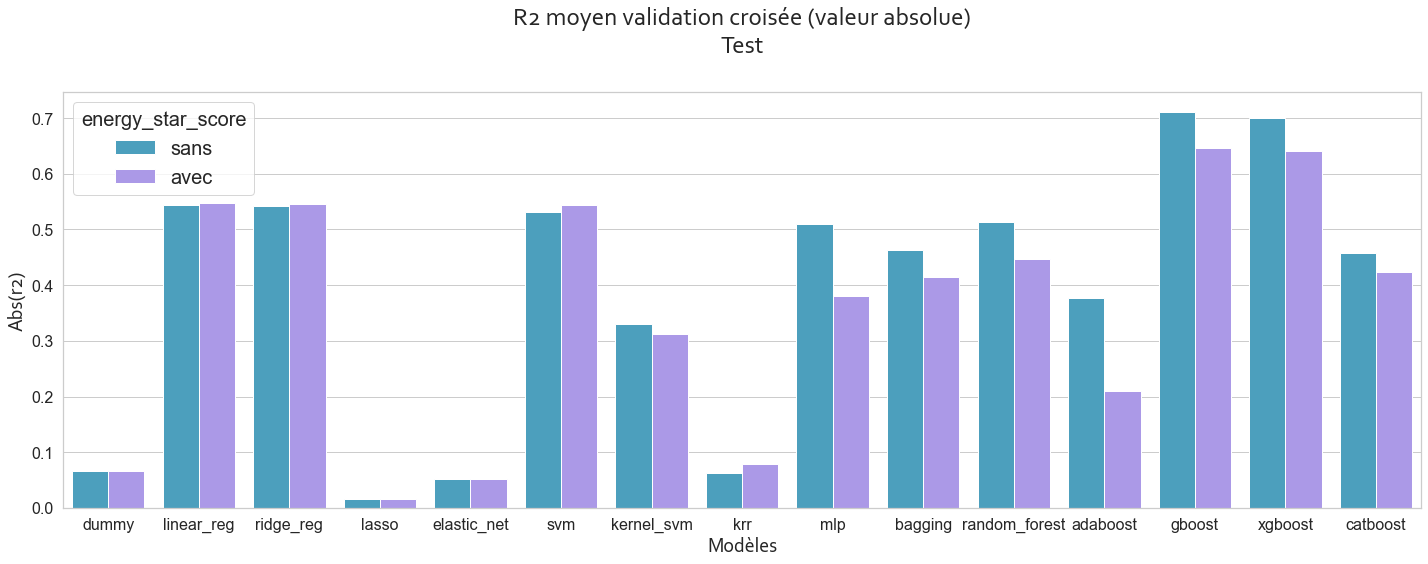

In [72]:
scores_copy = scores_test_all.copy()
scores_copy['Abs(r2)'] = scores_copy['r2'].abs()

titles = {'title': 'R2 moyen validation croisée (valeur absolue)\nTest', 'xlabel': 'Modèles'}
palette = sns.color_palette("husl", 8)[5:7]
toolbox.display_barplot(scores_copy, 'model', 'Abs(r2)',
                        titles, (20, 8), 'energy_star_score', True, palette)

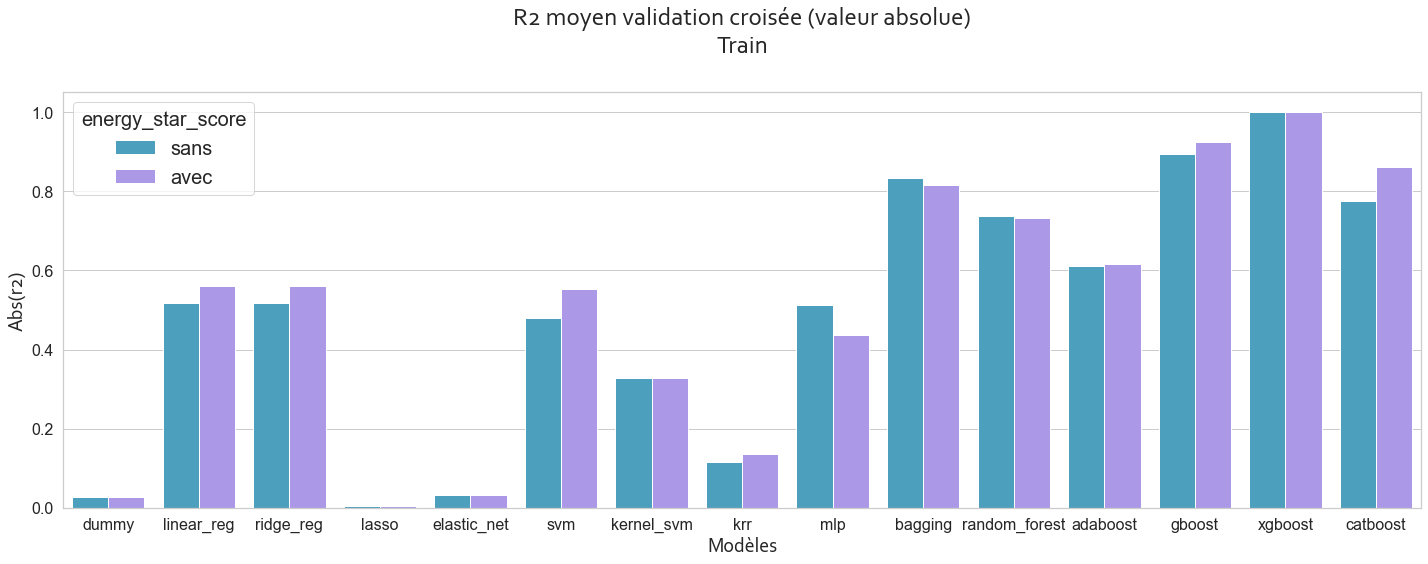

In [73]:
scores_copy = scores_train_all.copy()
scores_copy['Abs(r2)'] = scores_copy['r2'].abs()

titles = {'title': 'R2 moyen validation croisée (valeur absolue)\nTrain', 'xlabel': 'Modèles'}
palette = sns.color_palette("husl", 8)[5:7]
toolbox.display_barplot(scores_copy, 'model', 'Abs(r2)',
                        titles, (20, 8), 'energy_star_score', True, palette)

<h4 style="font-family:Corbel Light; color:#737373">Analyse Importance des features</h4>

Regardons quelle importance les modèles gradient boost, xgboost et forêt aléatoire accordent à l'energy star score

<Figure size 1656x720 with 0 Axes>

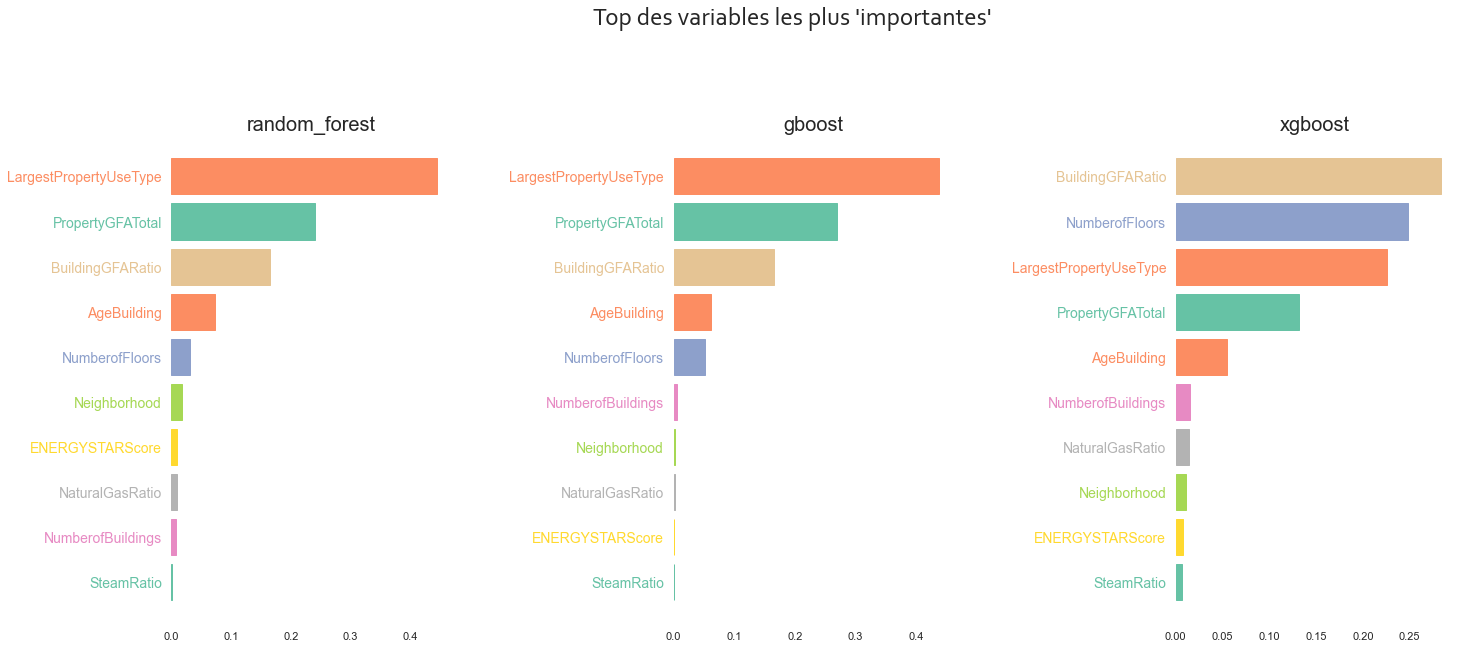

In [74]:
tree_models = []

regressors = [{'name': 'random_forest', 'regressor': RandomForestRegressor(random_state=8)},
              {'name': 'gboost', 'regressor': GradientBoostingRegressor(random_state=8)},
              {'name': 'xgboost', 'regressor': xgb.XGBRegressor(seed=8)}]

for model in regressors:
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        reg = toolbox.build_model(model['regressor'], transformers_star)
        reg.fit(X_star, y)

    tree_models.append({"name": model['name'], "model": reg.regressor_[1]})

toolbox.plot_feature_importance_tree_model(tree_models, X_star.columns, (23, 10), 20)

<h4 style="font-family:Corbel Light; color:#737373">Optimisation</h4>

<h5 style="font-family:Corbel Light; color:#737373">Gradient Boosting</h5>

In [75]:
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y, test_size=0.3, random_state=10)
datasets_star = {'X_train': X_star_train, 'y_train': y_star_train,
                 'X_test': X_star_test, 'y_test': y_star_test}

In [76]:
space_gb = {'n_estimators': scope.int(hp.quniform('n_estimators', 700, 1200, 1)),
            'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
            'learning_rate': hp.loguniform('learning_rate',  np.log(0.1), np.log(0.7)),
            'max_features': scope.int(hp.quniform('max_features', ceil(np.sqrt(X.shape[1])), X.shape[1], 1)),
            # 'n_iter_no_change' : scope.int(hp.quniform('n_iter_no_change', 5, 100, 1)),
            # 'min_samples_leaf' : scope.int(hp.quniform('min_samples_leaf', 2, 10, 1)),
            # 'min_samples_split' : scope.int(hp.quniform('min_samples_split', 2, 15, 1))
            }

trials_gb_star = Trials()

print("-R2 sans optimisation : {:.4f}\n".format(gb_r2_cv({}, X_star_train, y_star_train, transformers_star)))

best_params_gb_star = fmin(fn=partial(gb_r2_cv, X=X_star_train, y=y_star_train, transformers=transformers_star),
                           space=space_gb,
                           algo=tpe.suggest,
                           max_evals=70,
                           trials=trials_gb_star,
                           rstate=np.random.default_rng(8),
                           # early_stop_fn=no_progress_loss(10)
                           )

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


-R2 sans optimisation : -0.5880

100%|██████████| 70/70 [05:41<00:00,  4.88s/trial, best loss: -0.7092975865418012]


In [77]:
best_model_gb_star = GradientBoostingRegressor(random_state=8, n_iter_no_change=3,
                                               n_estimators=int(best_params_gb_star['n_estimators']),
                                               max_depth=int(best_params_gb_star['max_depth']),
                                               learning_rate=best_params_gb_star['learning_rate'],
                                               max_features=int(best_params_gb_star['max_features']),
                                               # n_iter_no_change=int(best_params_gb_star['n_iter_no_change']),
                                               # min_samples_leaf=int(best_params_gb_star['min_samples_leaf']),
                                               # min_samples_split=int(best_params_gb_star['min_samples_split'])
                                               )
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    best_model_gb_star_fit = toolbox.score_best_model(best_model_gb_star, transformers_star, best_params_gb_star, datasets_star)

,Param,Best Param
0,learning_rate,0.41420
1,max_depth,2.00000
2,max_features,8.00000
3,n_estimators,920.00000


Modèle optimisé : 
Test R2 : 0.7927
Temps d'entrainement : 0.242
Train R2 : 0.8192

Ecart type R2 (validation croisée sur train set) : 0.2842


In [78]:
print('Rappel résultats du modèle optimisé sans energy star score')
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    gb_no_star = toolbox.score_best_model(best_model_gb, transformers, best_params_gb, datasets)

Rappel résultats du modèle optimisé sans energy star score


,Param,Best Param
0,learning_rate,0.14689
1,max_depth,2.00000
2,max_features,5.00000
3,n_estimators,388.00000


Modèle optimisé : 
Test R2 : 0.8592
Temps d'entrainement : 0.528
Train R2 : 0.9066

Ecart type R2 (validation croisée sur train set) : 0.3272


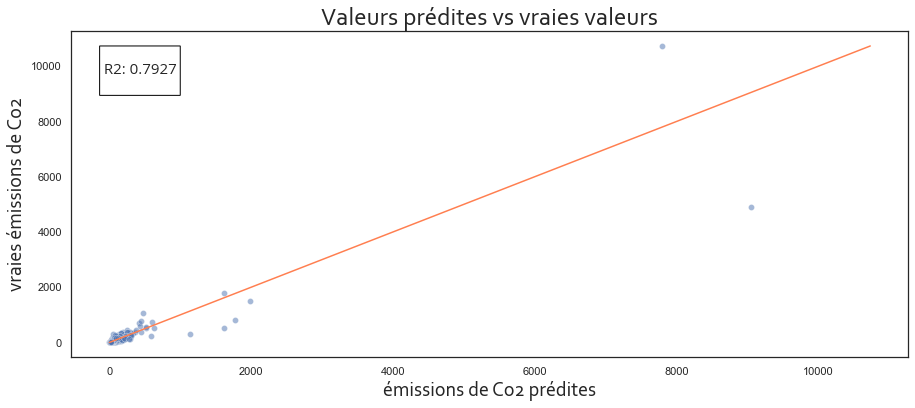

In [79]:
toolbox.plot_test_vs_pred(best_model_gb_star_fit, y_star_test,
                          X_star_test, 'TotalGHGEmissions', 'émissions de Co2', 1000)

<h5 style="font-family:Corbel Light; color:#737373">XGBoost</h5>

In [80]:
space_xgb = {'eta': hp.loguniform('eta', np.log(0.1), np.log(0.7)),
             'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
             'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
             'gamma': hp.uniform('gamma', 0, 100),
             'reg_lambda': hp.uniform('reg_lambda', 0, 100),
             'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1300, 1)),
             'subsample': hp.uniform('subsample', 0.7, 1)
             }

trials_xgb = Trials()

print("-R2 sans optimisation : {:.4f}\n".format(xgb_r2_cv({}, X_star_train, y_star_train, transformers_star)))

best_params_xgb_star = fmin(fn=partial(xgb_r2_cv, X=X_star_train, y=y_star_train, transformers=transformers_star),
                            space=space_xgb,
                            algo=tpe.suggest,
                            max_evals=100,
                            trials=trials_xgb,
                            rstate=np.random.default_rng(8),
                            # early_stop_fn=no_progress_loss(30)
                            )

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


-R2 sans optimisation : -0.5055

100%|██████████| 100/100 [02:42<00:00,  1.62s/trial, best loss: -0.6387906172932989]


In [81]:
best_model_xgb_star = xgb.XGBRegressor(seed=8,
                                       max_depth=int(best_params_xgb_star['max_depth']),
                                       eta=best_params_xgb_star['eta'],
                                       colsample_bytree=best_params_xgb_star['colsample_bytree'],
                                       gamma=best_params_xgb_star['gamma'],
                                       reg_lambda=best_params_xgb_star['reg_lambda'],
                                       n_estimators=int(best_params_xgb_star['n_estimators']),
                                       subsample=best_params_xgb_star['subsample']
                                       )
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    best_model_xgb_star_fit = toolbox.score_best_model(best_model_xgb_star,
                                                       transformers_star,
                                                       best_params_xgb_star,
                                                       datasets_star
                                                       )

,Param,Best Param
0,colsample_bytree,0.51130
1,eta,0.18335
2,gamma,0.11999
3,max_depth,3.00000
4,n_estimators,545.00000
5,reg_lambda,8.28944
6,subsample,0.81052


Modèle optimisé : 
Test R2 : 0.8602
Temps d'entrainement : 0.556
Train R2 : 0.9302

Ecart type R2 (validation croisée sur train set) : 0.3414


In [82]:
print('Rappel : résultats du modèle optimisé sans energy star score')
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    model_no_star = toolbox.score_best_model(best_model_xgb, transformers, best_params_xgb, datasets)

Rappel : résultats du modèle optimisé sans energy star score


,Param,Best Param
0,colsample_bytree,0.31582
1,eta,0.18335
2,gamma,0.11999
3,max_depth,3.00000
4,n_estimators,581.00000
5,reg_lambda,8.28944
6,subsample,0.81052


Modèle optimisé : 
Test R2 : 0.9129
Temps d'entrainement : 0.537
Train R2 : 0.9371

Ecart type R2 (validation croisée sur train set) : 0.3582


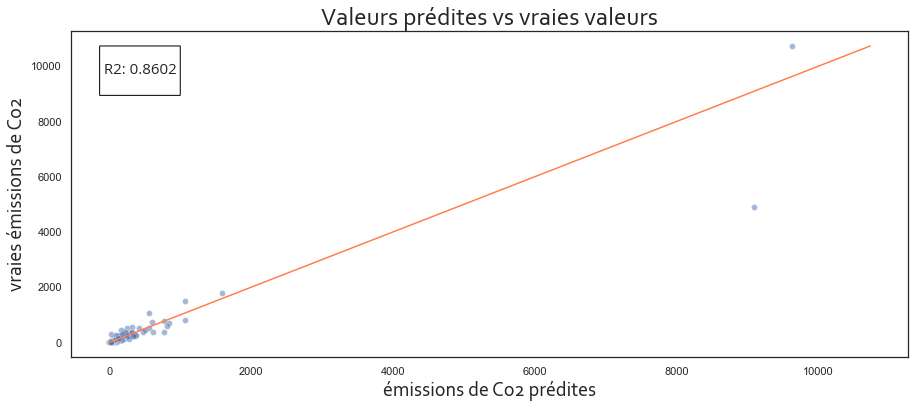

In [83]:
toolbox.plot_test_vs_pred(best_model_xgb_star_fit, y_star_test, X_star_test, 'TotalGHGEmissions', 'émissions de Co2', 1000)

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#e54b87">Conclusion</span></h2>

- Sur la qualité du modèle : On a retenu le modèle Xgboost. Cependant, on a construit notre modèle avec un jeu de données très réduit, il n’est pas très robuste.

- Sur l’utilité de l’energy star score : Assez surprenamment il fait baisser les résultats (peut-être qu'il introduit du bruit dans ce modèle). De plus il nous force à beaucoup réduire le nombre d’observations et donc à perdre beaucoup d’informations. Je conseillerai donc à l’équipe de ne pas l’utiliser pour les prédictions. 